In [1]:

# %% [Usage]
# To run end-to-end, execute all cells top-to-bottom.
# Dependencies: project package `calcium_activity_characterization` must be importable.

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns

# Project path setup
project_root = Path.cwd().parent
source_path = project_root / "src"
if source_path.exists() and str(source_path) not in sys.path:
    sys.path.insert(0, str(source_path))

# Style
sns.set_style("whitegrid", rc={"font.family": "sans-serif", "font.sans-serif": ["Arial"]})

# Logging
from calcium_activity_characterization.logger import logger

# Project utilities
from calcium_activity_characterization.io.csv_loader import load_dataset
from calcium_activity_characterization.analysis.statistics import (
    analyze_peak_intervals,
    build_neighbor_pair_stats,
    brunner_pairs,
    brunner_pairs,
    wilcoxon_pairs,
    corr_nonparametric,
)

# Visualizers (from your helper file)
from calcium_activity_characterization.analysis.visualizers import (
    plot_violin,
    plot_points_mean_std,
    visualize_image,
    plot_scatter_size_coded,
    plot_histogram,
    plot_histogram_by_group,
    plot_pie_chart,
    plot_bar,
    plot_xy_with_regression,
    plot_heatmap,
    plot_early_peakers_heatmap,
    plot_category_distribution_by_dataset,
)


In [2]:

# --- Configuration ---
# Root containing your CSVs
DATA_ROOT = Path("D:/Mateo/Results")

# Output directories for figures (tweak as needed)
FIG_ACH = Path("C:/Users/poseidon/OneDrive/Documents/01_ETHZ/Master_Degree/Spring_Semester_2025/Master_Thesis/Report/Figures/Chapter_4")
FIG_CTRL = Path("C:/Users/poseidon/OneDrive/Documents/01_ETHZ/Master_Degree/Spring_Semester_2025/Master_Thesis/Report/Figures/Chapter_3")
FIG_ACH.mkdir(parents=True, exist_ok=True)
FIG_CTRL.mkdir(parents=True, exist_ok=True)

# --- Load CSVs ---
experiments = load_dataset(path=str(DATA_ROOT), file_name="merged_experiments.csv") if (DATA_ROOT / "merged_experiments.csv").exists() else load_dataset(path=str(DATA_ROOT), file_name="experiments.csv")
peaks        = load_dataset(path=str(DATA_ROOT), file_name="merged_peaks.csv")
cells        = load_dataset(path=str(DATA_ROOT), file_name="merged_cells.csv")
events       = load_dataset(path=str(DATA_ROOT), file_name="merged_events.csv")
communications = load_dataset(path=str(DATA_ROOT), file_name="merged_communications.csv")

logger.info("Loaded tables: exp=%s peaks=%s cells=%s events=%s comm=%s",
            experiments.shape, peaks.shape, cells.shape, events.shape, communications.shape)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")


[2025-08-26 14:49:28] [INFO] calcium: Loaded tables: exp=(71, 9) peaks=(371621, 32) cells=(59342, 23) events=(38384, 35) comm=(97580, 21)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")


In [3]:
# --- Harmonize keys, compute density once, and propagate condition labels ---

# 0) Safety: required columns
required_cols = {"dataset", "concentration"}
for name, df in {
    "experiments": experiments, "peaks": peaks, "cells": cells,
    "events": events, "communications": communications
}.items():
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"{name} missing columns: {missing}")

# 1) Canonicalize dataset keys everywhere: "<dataset>_<concentration>"
for df in (experiments, peaks, cells, events, communications):
    df["dataset"] = df["dataset"].astype(str) + "_" + df["concentration"].astype(str)

# 2) Compute cell density (number of cells per canonical dataset) and map into all tables
cell_counts = cells.groupby("dataset")["Cell ID"].count()
for df in (experiments, events, cells, peaks, communications):
    df["Dataset cell density"] = df["dataset"].map(cell_counts)

# 3) Make sure peaks have an event label
peaks["In event"] = peaks["In event"].fillna("individual")

# --- Build cohort sets from experiments (using your filters) ---
ACH_FILTER = (
    (experiments["condition"] == "ACH - 1st run")
    & (experiments["time"] == "+2d")
    & (experiments["Dataset cell density"] > 900)
)
CTRL_FILTER = (
    (experiments["condition"] == "control - 1st run")
    & (experiments["Dataset cell density"] > 900)
)

ach_experiments = experiments.loc[ACH_FILTER].copy()
ctrl_experiments = experiments.loc[CTRL_FILTER].copy()

ds_ach  = set(ach_experiments["dataset"])
ds_ctrl = set(ctrl_experiments["dataset"])

# --- Create a de-duplicated (dataset -> condition_group) mapping ---
cond_key = experiments[["dataset"]].drop_duplicates()
cond_key["condition_group"] = np.where(
    cond_key["dataset"].isin(ds_ach), "ACH",
    np.where(cond_key["dataset"].isin(ds_ctrl), "Control", "Other")
)

# --- Attach condition_group to EVERY table via 1:m merge ---
def _attach_condition(df: pd.DataFrame) -> pd.DataFrame:
    # validate="m:1" guards against accidental many-to-many joins
    return df.merge(cond_key, on="dataset", how="left", validate="m:1")

experiments    = _attach_condition(experiments)
peaks          = _attach_condition(peaks)
cells          = _attach_condition(cells)
events         = _attach_condition(events)
communications = _attach_condition(communications)

# --- Sanity checks (optional but helpful) ---
for name, df in [("experiments", experiments), ("peaks", peaks), ("cells", cells),
                 ("events", events), ("communications", communications)]:
    assert "condition_group" in df.columns, f"{name} is missing condition_group"
    # Uncomment to inspect distribution:
    # print(name, df["condition_group"].value_counts(dropna=False).to_dict())

ach_peaks = peaks[peaks["condition_group"] == "ACH"]
ctrl_peaks = peaks[peaks["condition_group"] == "Control"]

ach_cells = cells[cells["condition_group"] == "ACH"]
ctrl_cells = cells[cells["condition_group"] == "Control"]

ach_events = events[events["condition_group"] == "ACH"]
ctrl_events = events[events["condition_group"] == "Control"]

ach_comms = communications[communications["condition_group"] == "ACH"]
ctrl_comms = communications[communications["condition_group"] == "Control"]

# Keep only ACH / Control rows, drop the 'Other'
valid_conditions = {"ACH", "Control"}

experiments    = experiments[experiments["condition_group"].isin(valid_conditions)].copy()
peaks          = peaks[peaks["condition_group"].isin(valid_conditions)].copy()
cells          = cells[cells["condition_group"].isin(valid_conditions)].copy()
events         = events[events["condition_group"].isin(valid_conditions)].copy()
communications = communications[communications["condition_group"].isin(valid_conditions)].copy()


[2025-08-26 14:49:30] [INFO] calcium: ACH groups (concentrations) found: ['100nM', '10nM', '10uM', '1uM']
[2025-08-26 14:49:30] [INFO] calcium: ACH event counts by dataset and type (head):
   ach_group              dataset       Event type  n_events
0      100nM   20250424_IS7_100nM      GlobalEvent         2
1      100nM   20250424_IS7_100nM  SequentialEvent      1025
2      100nM  20250624_IS09_100nM      GlobalEvent         6
3      100nM  20250624_IS09_100nM  SequentialEvent       250
4      100nM  20250624_IS10_100nM      GlobalEvent         7
5      100nM  20250624_IS10_100nM  SequentialEvent       421
6       10nM    20250618_IS7_10nM      GlobalEvent         4
7       10nM    20250618_IS7_10nM  SequentialEvent       626
8       10nM    20250618_IS8_10nM      GlobalEvent         4
9       10nM    20250618_IS8_10nM  SequentialEvent       375
10      10uM    20250618_IS1_10uM      GlobalEvent         4
11      10uM    20250618_IS1_10uM  SequentialEvent       564
12      10uM    20

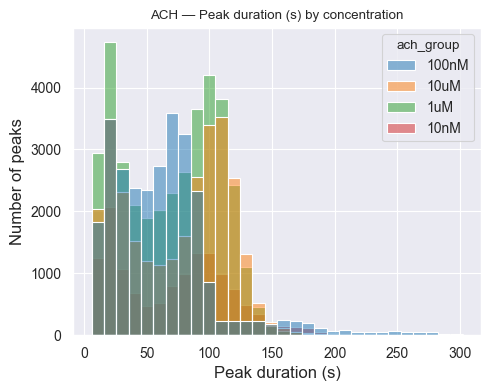

[2025-08-26 14:49:31] [INFO] calcium: plot_histogram_by_group: removed 15 outliers out of 107677 on 'Prominence (noise std units)' (lower=-578.8, upper=862.5)


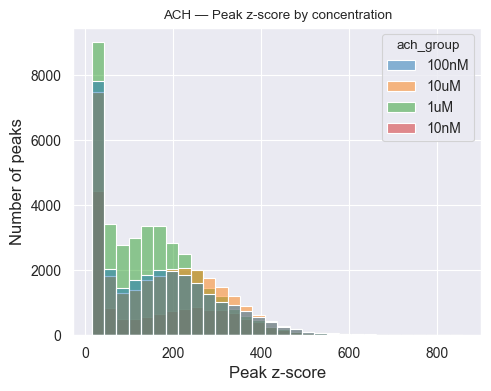

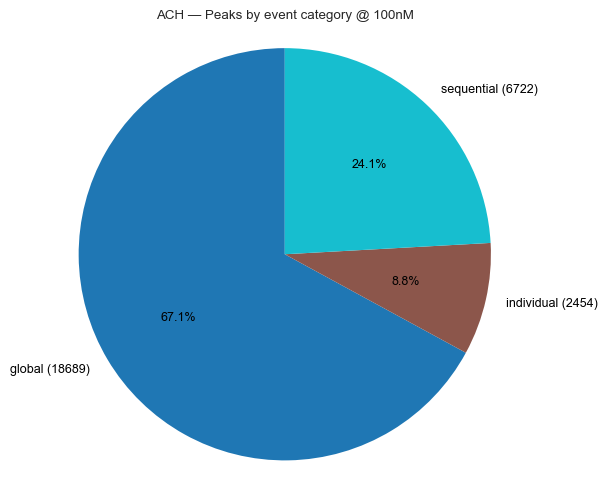

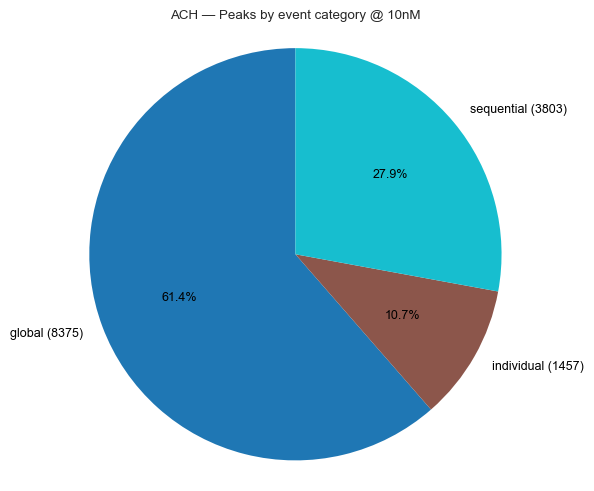

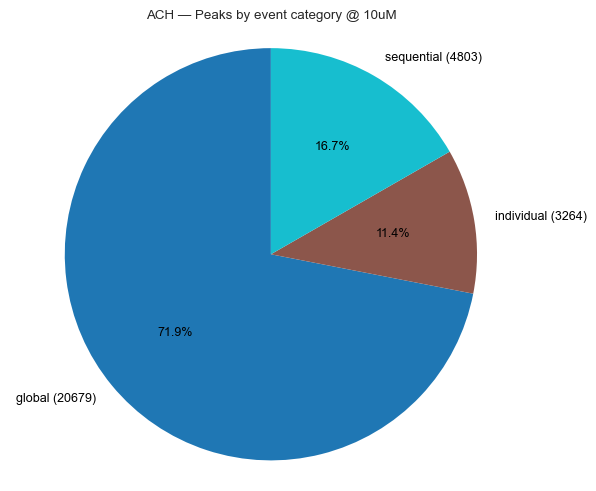

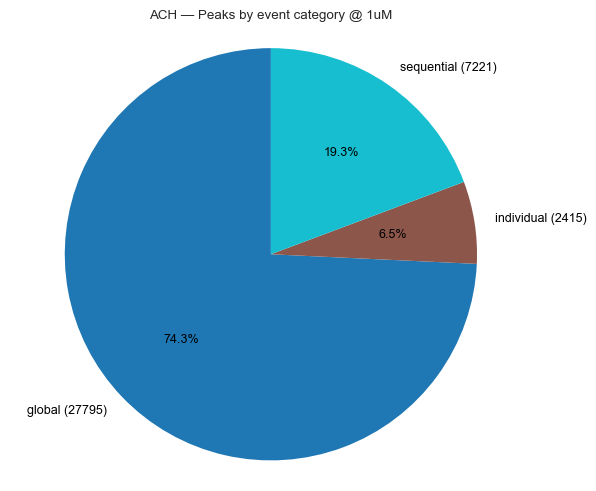

[2025-08-26 14:49:32] [INFO] calcium: plot_violin: removed 766 outliers out of 75538 on 'Duration (s)' (lower=-61, upper=233)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


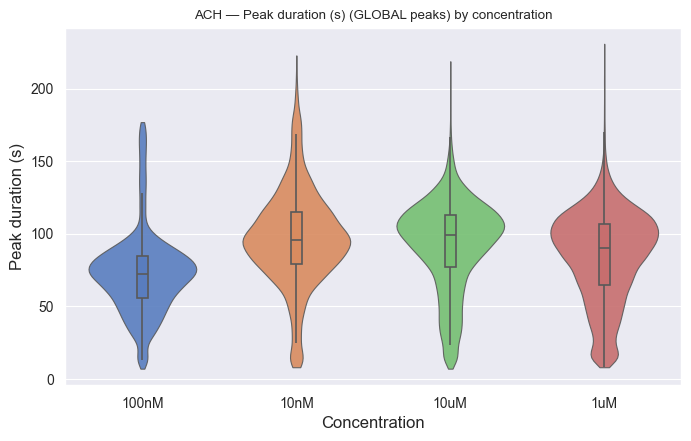

[2025-08-26 14:49:33] [INFO] calcium: plot_violin: removed 766 outliers out of 75538 on 'Duration (s)' (lower=-61, upper=233)
[2025-08-26 14:49:38] [INFO] calcium: plot_violin: removed 47 outliers out of 75538 on 'Prominence (noise std units)' (lower=-310.4, upper=789.3)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


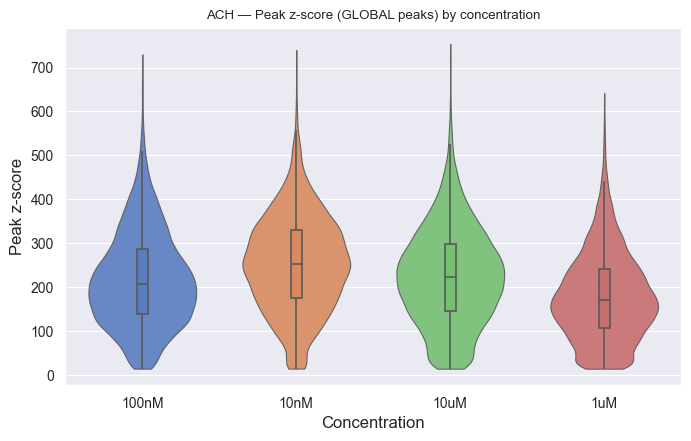

[2025-08-26 14:49:38] [INFO] calcium: plot_violin: removed 47 outliers out of 75538 on 'Prominence (noise std units)' (lower=-310.4, upper=789.3)
[2025-08-26 14:49:42] [INFO] calcium: plot_violin: removed 378 outliers out of 22549 on 'Duration (s)' (lower=-42, upper=98)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


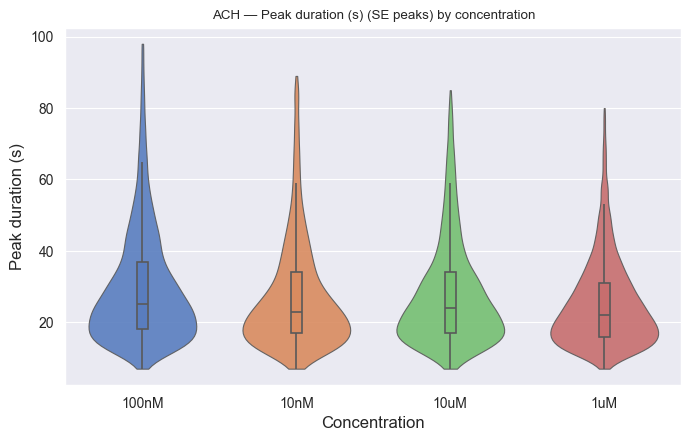

[2025-08-26 14:49:43] [INFO] calcium: plot_violin: removed 378 outliers out of 22549 on 'Duration (s)' (lower=-42, upper=98)
[2025-08-26 14:49:44] [INFO] calcium: plot_violin: removed 682 outliers out of 22549 on 'Prominence (noise std units)' (lower=-66.6, upper=137.8)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


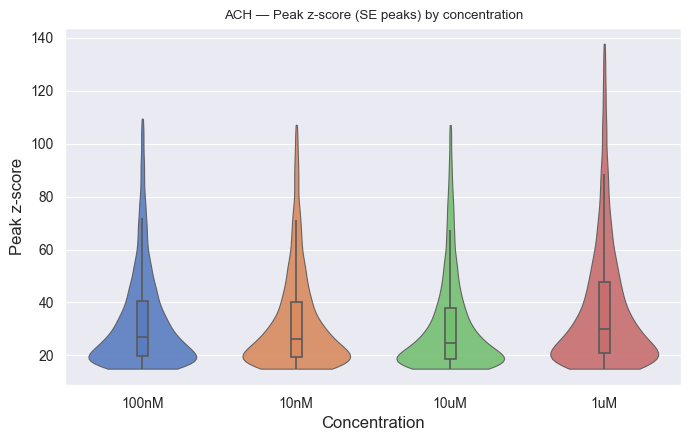

[2025-08-26 14:49:45] [INFO] calcium: plot_violin: removed 682 outliers out of 22549 on 'Prominence (noise std units)' (lower=-66.6, upper=137.8)
[2025-08-26 14:49:46] [INFO] calcium: plot_violin: removed 239 outliers out of 9590 on 'Duration (s)' (lower=-38, upper=88)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


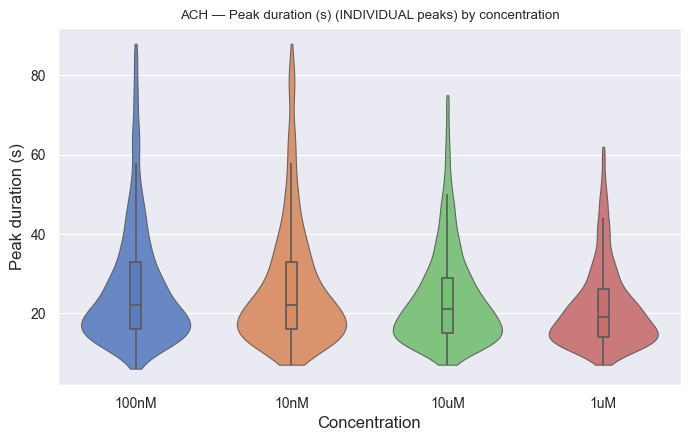

[2025-08-26 14:49:46] [INFO] calcium: plot_violin: removed 239 outliers out of 9590 on 'Duration (s)' (lower=-38, upper=88)
[2025-08-26 14:49:47] [INFO] calcium: plot_violin: removed 341 outliers out of 9590 on 'Prominence (noise std units)' (lower=-32.25, upper=84.3)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


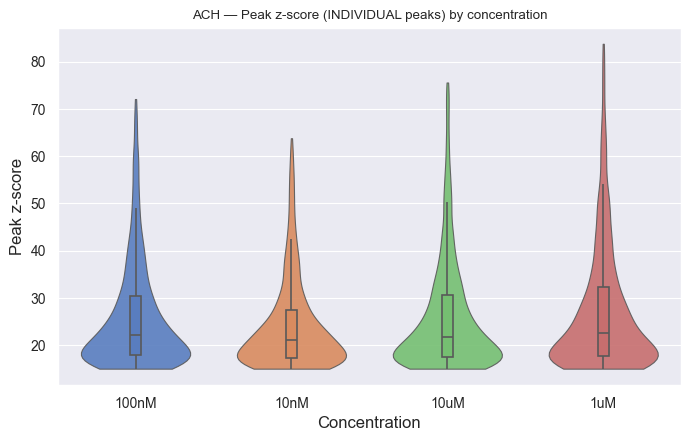

[2025-08-26 14:49:47] [INFO] calcium: plot_violin: removed 341 outliers out of 9590 on 'Prominence (noise std units)' (lower=-32.25, upper=84.3)
[2025-08-26 14:49:48] [INFO] calcium: plot_points_mean_std: N=15 for ach_group=100nM
[2025-08-26 14:49:48] [INFO] calcium: plot_points_mean_std: N=8 for ach_group=10nM
[2025-08-26 14:49:48] [INFO] calcium: plot_points_mean_std: N=19 for ach_group=10uM
[2025-08-26 14:49:48] [INFO] calcium: plot_points_mean_std: N=23 for ach_group=1uM


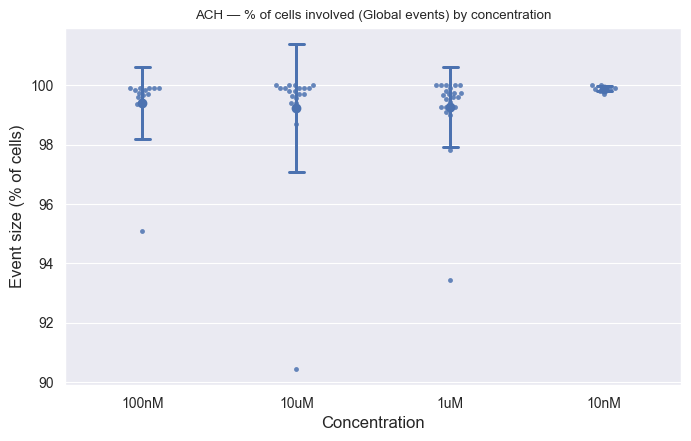

[2025-08-26 14:49:49] [INFO] calcium: plot_points_mean_std: removed 1/65 outliers on 'Time to 50% (s)' (lower=-36, upper=146)
[2025-08-26 14:49:49] [INFO] calcium: plot_points_mean_std: N=15 for ach_group=100nM
[2025-08-26 14:49:49] [INFO] calcium: plot_points_mean_std: N=7 for ach_group=10nM
[2025-08-26 14:49:49] [INFO] calcium: plot_points_mean_std: N=19 for ach_group=10uM
[2025-08-26 14:49:49] [INFO] calcium: plot_points_mean_std: N=23 for ach_group=1uM


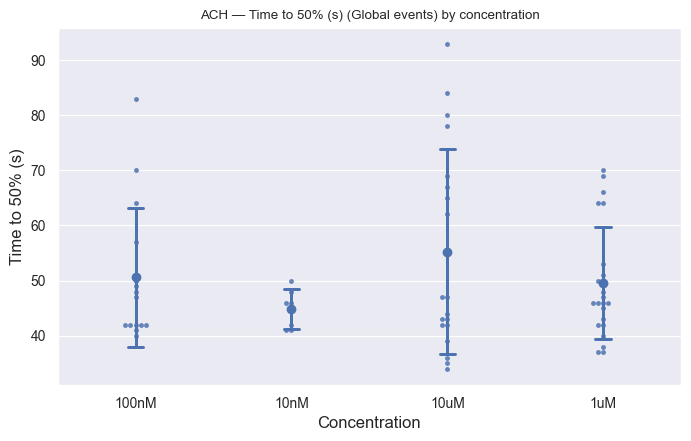

[2025-08-26 14:49:50] [INFO] calcium: plot_points_mean_std: removed 1/65 outliers on 'Normalized peak rate at 50% (% of peaks/s)' (lower=-1.4, upper=5.6)
[2025-08-26 14:49:50] [INFO] calcium: plot_points_mean_std: N=15 for ach_group=100nM
[2025-08-26 14:49:50] [INFO] calcium: plot_points_mean_std: N=7 for ach_group=10nM
[2025-08-26 14:49:50] [INFO] calcium: plot_points_mean_std: N=19 for ach_group=10uM
[2025-08-26 14:49:50] [INFO] calcium: plot_points_mean_std: N=23 for ach_group=1uM


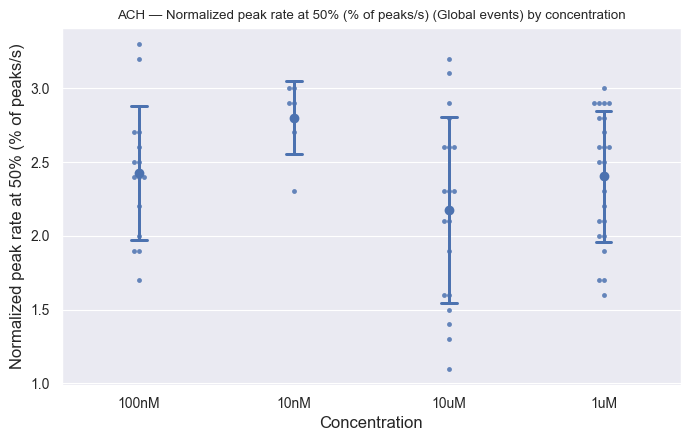

[2025-08-26 14:49:50] [INFO] calcium: plot_violin: removed 198 outliers out of 16615 on 'Speed (um/s)' (lower=-18.36, upper=28.26)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


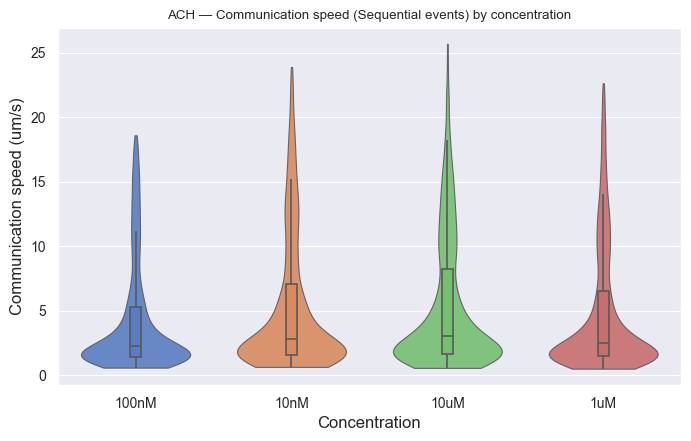

[2025-08-26 14:49:50] [INFO] calcium: plot_violin: removed 198 outliers out of 16615 on 'Speed (um/s)' (lower=-18.36, upper=28.26)
[2025-08-26 14:49:51] [INFO] calcium: plot_histogram_by_group: removed 8 outliers out of 16615 on 'Distance (um)' (lower=-4.69, upper=35.42)


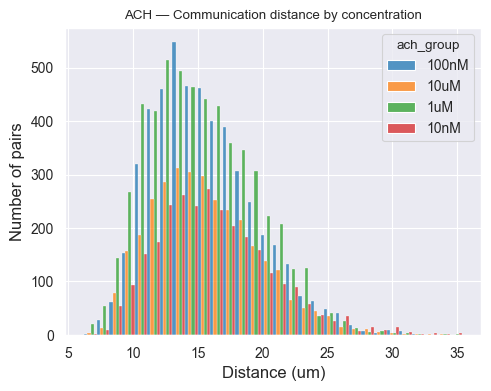

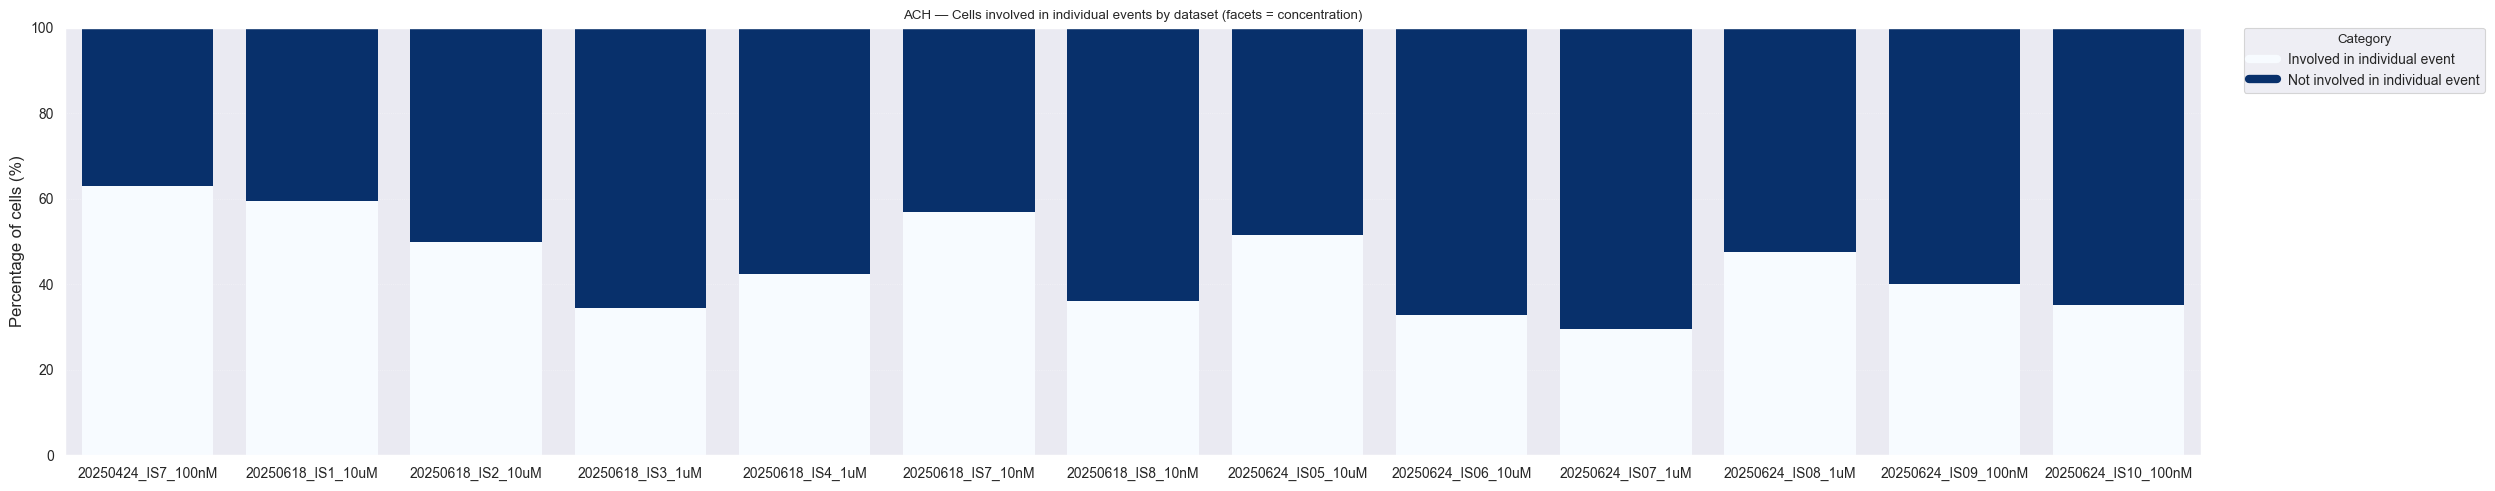

[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: removed 1/3555 outliers on 'Y' (lower=-9, upper=12)
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=1948 for X=0
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=1017 for X=1
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=408 for X=2
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=127 for X=3
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=41 for X=4
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=8 for X=5
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=3 for X=6
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=1 for X=8
[2025-08-26 14:49:52] [INFO] calcium: plot_points_mean_std: N=1 for X=9


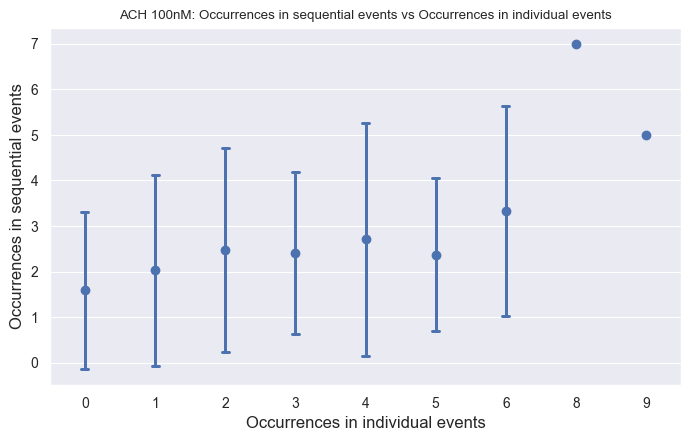

[2025-08-26 14:49:53] [INFO] calcium: plot_points_mean_std: removed 0/3555 outliers on 'Y' (lower=-13, upper=22)
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=948 for X=0
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=1020 for X=1
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=645 for X=2
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=298 for X=3
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=226 for X=4
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=181 for X=5
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=126 for X=6
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=56 for X=7
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=37 for X=8
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=9 for X=9
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=5 for X=10
[2025-08-26 14:49:54] [INFO] calcium: plot_points_mean_std: N=2 for X=11
[202

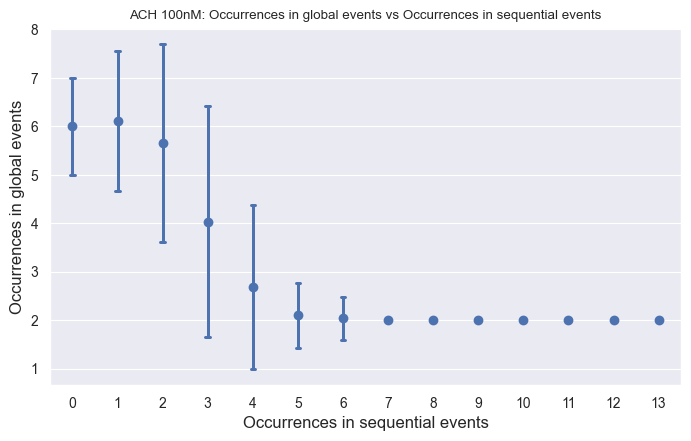

[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: removed 0/3555 outliers on 'Y' (lower=-13, upper=22)
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=1948 for X=0
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=1018 for X=1
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=408 for X=2
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=127 for X=3
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=41 for X=4
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=8 for X=5
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=3 for X=6
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=1 for X=8
[2025-08-26 14:49:55] [INFO] calcium: plot_points_mean_std: N=1 for X=9


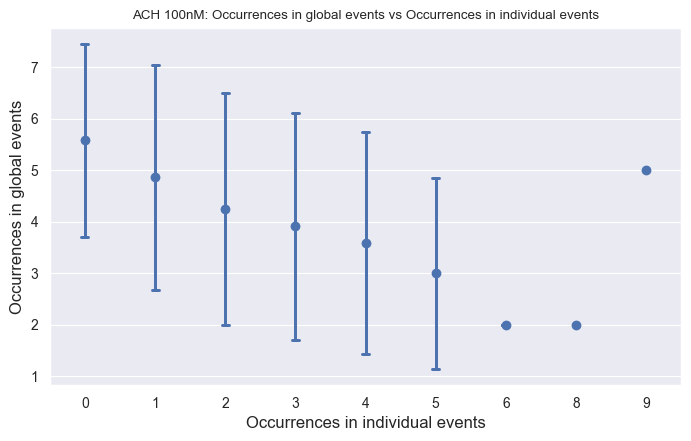

[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: removed 0/2019 outliers on 'Y' (lower=-5, upper=9)
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=1063 for X=0
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=607 for X=1
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=234 for X=2
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=91 for X=3
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=15 for X=4
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=7 for X=5
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=1 for X=6
[2025-08-26 14:49:56] [INFO] calcium: plot_points_mean_std: N=1 for X=8


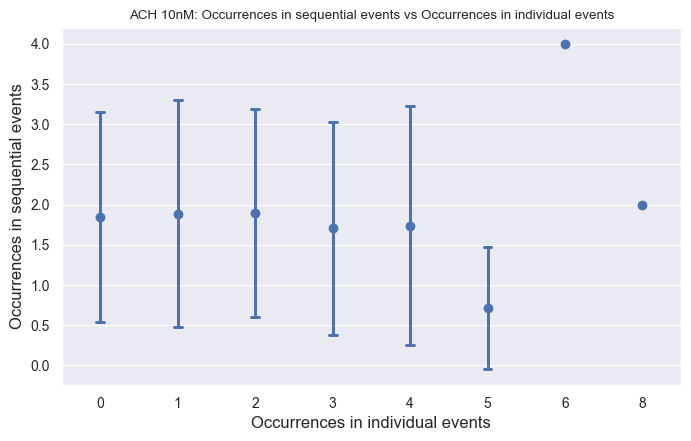

[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: removed 9/2019 outliers on 'Y' (lower=4, upper=4)
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=315 for X=0
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=567 for X=1
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=542 for X=2
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=355 for X=3
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=168 for X=4
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=45 for X=5
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=12 for X=6
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=4 for X=7
[2025-08-26 14:49:58] [INFO] calcium: plot_points_mean_std: N=2 for X=9


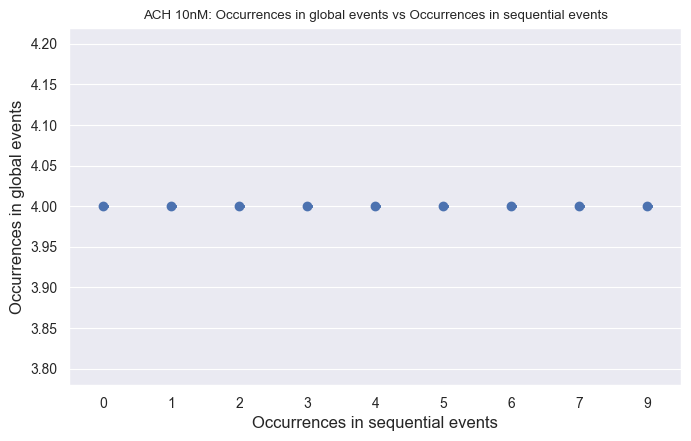

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\.venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:165: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigsq)


[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: removed 9/2019 outliers on 'Y' (lower=4, upper=4)
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=1061 for X=0
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=606 for X=1
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=231 for X=2
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=88 for X=3
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=15 for X=4
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=7 for X=5
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=1 for X=6
[2025-08-26 14:49:59] [INFO] calcium: plot_points_mean_std: N=1 for X=8


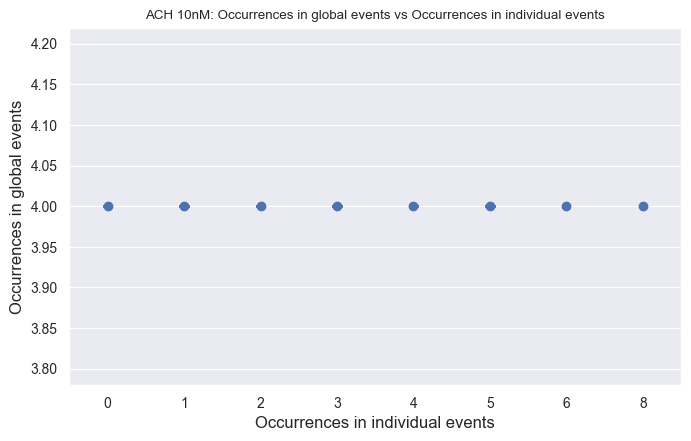

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\.venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:165: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigsq)


[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: removed 0/4264 outliers on 'Y' (lower=-6, upper=8)
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=2178 for X=0
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=1297 for X=1
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=510 for X=2
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=200 for X=3
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=56 for X=4
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=17 for X=5
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=5 for X=6
[2025-08-26 14:50:00] [INFO] calcium: plot_points_mean_std: N=1 for X=8


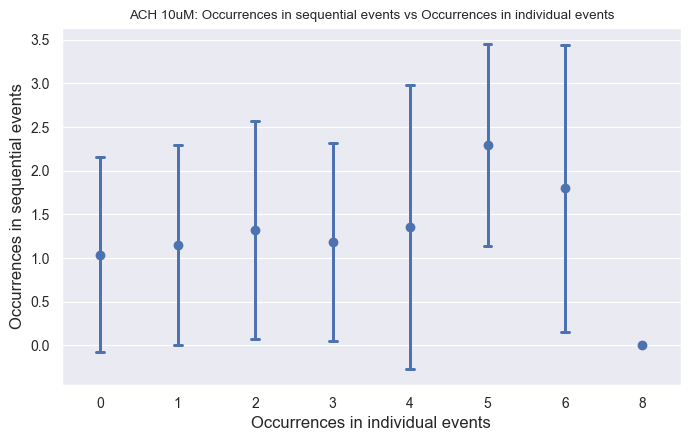

[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: removed 0/4264 outliers on 'Y' (lower=1, upper=8)
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=1510 for X=0
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=1451 for X=1
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=811 for X=2
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=334 for X=3
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=100 for X=4
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=36 for X=5
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=14 for X=6
[2025-08-26 14:50:01] [INFO] calcium: plot_points_mean_std: N=8 for X=7


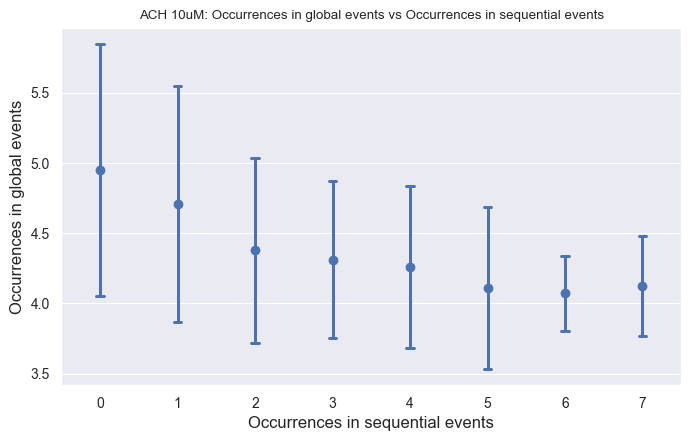

[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: removed 0/4264 outliers on 'Y' (lower=1, upper=8)
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=2178 for X=0
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=1297 for X=1
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=510 for X=2
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=200 for X=3
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=56 for X=4
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=17 for X=5
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=5 for X=6
[2025-08-26 14:50:03] [INFO] calcium: plot_points_mean_std: N=1 for X=8


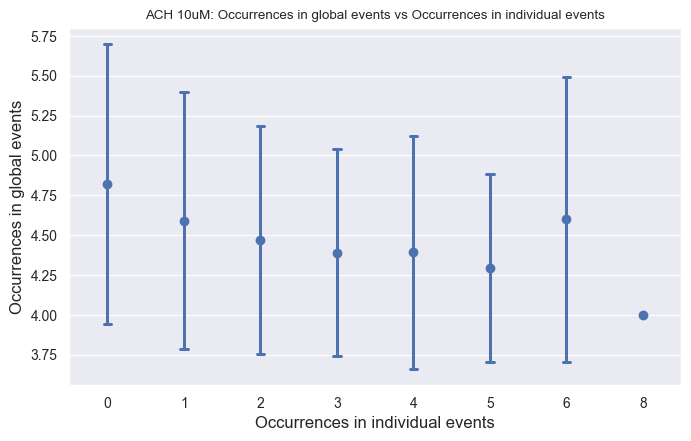

[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: removed 40/4551 outliers on 'Y' (lower=-2, upper=5)
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=2802 for X=0
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=1231 for X=1
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=352 for X=2
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=79 for X=3
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=30 for X=4
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=12 for X=5
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=3 for X=6
[2025-08-26 14:50:05] [INFO] calcium: plot_points_mean_std: N=2 for X=7


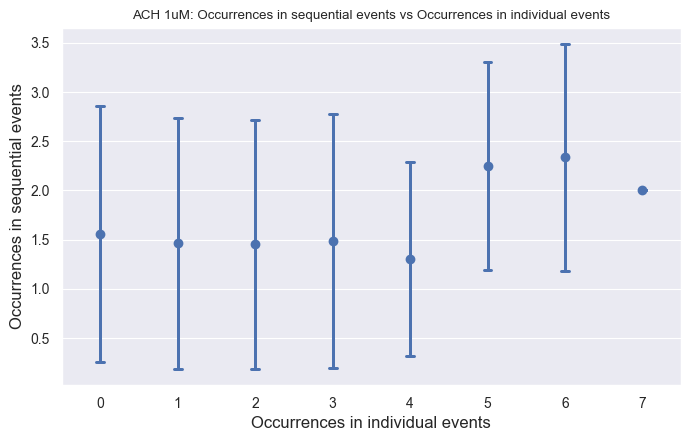

[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: removed 0/4551 outliers on 'Y' (lower=-1, upper=13)
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=1050 for X=0
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=1548 for X=1
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=936 for X=2
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=577 for X=3
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=288 for X=4
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=112 for X=5
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=31 for X=6
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=7 for X=7
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=1 for X=8
[2025-08-26 14:50:06] [INFO] calcium: plot_points_mean_std: N=1 for X=9


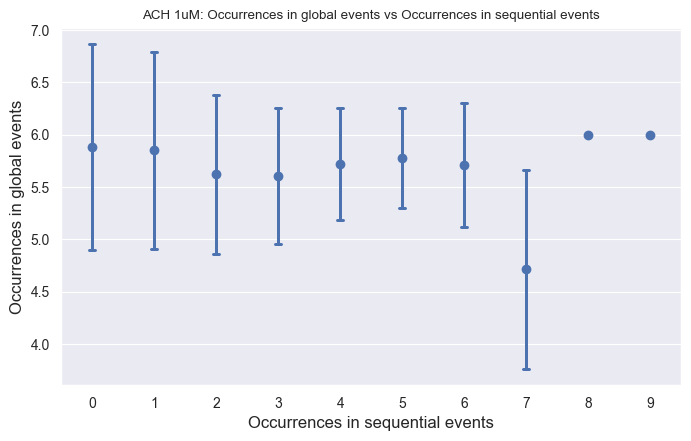

[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: removed 0/4551 outliers on 'Y' (lower=-1, upper=13)
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=2826 for X=0
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=1239 for X=1
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=358 for X=2
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=79 for X=3
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=31 for X=4
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=12 for X=5
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=3 for X=6
[2025-08-26 14:50:08] [INFO] calcium: plot_points_mean_std: N=3 for X=7


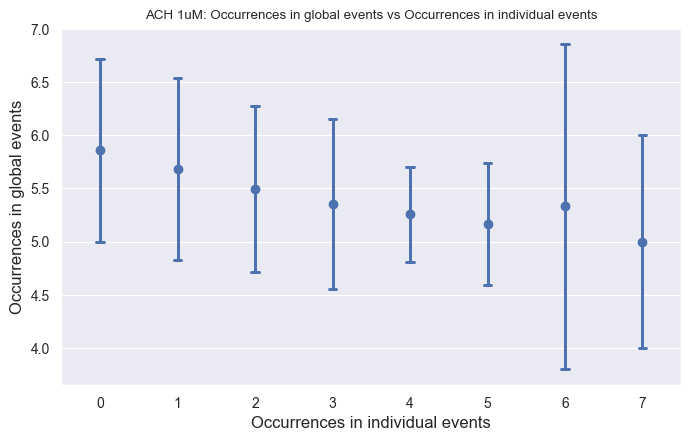

[2025-08-26 14:50:10] [INFO] calcium: ACH by concentration analysis complete.


In [4]:
# %% [ACH — by concentration]
# Usage:
# 1) Run after data loading + canonicalization in this notebook.
# 2) Produces ACH-only comparisons across concentrations (ach_group).

# --- Build ACH-only cohorts grouped by concentration --------------------------
ach_experiments_only = experiments[experiments["condition_group"] == "ACH"].copy()
ach_peaks_only       = peaks[peaks["condition_group"] == "ACH"].copy()
ach_cells_only       = cells[cells["condition_group"] == "ACH"].copy()
ach_events_only      = events[events["condition_group"] == "ACH"].copy()
ach_comms_only       = communications[communications["condition_group"] == "ACH"].copy()

# Map dataset -> concentration for ACH datasets
ds_to_conc = ach_experiments_only.set_index("dataset")["concentration"].to_dict()

# Attach ach_group (= concentration) across ACH tables; drop non-ACH rows defensively
for _df in (ach_experiments_only, ach_peaks_only, ach_cells_only, ach_events_only, ach_comms_only):
    _df["ach_group"] = _df["dataset"].map(ds_to_conc)
    _df.dropna(subset=["ach_group"], inplace=True)

ach_groups = sorted(ach_experiments_only["ach_group"].unique().tolist())

# Quick sanity log
logger.info("ACH groups (concentrations) found: %s", ach_groups)

# ==============================================================================
# 1) Event composition & counts — ACH by concentration
# ==============================================================================

# (A) Event counts per dataset (table output if you want to inspect)
ach_ev_counts_conc = (
    ach_events_only
    .groupby(["ach_group", "dataset", "Event type"], as_index=False)
    .size()
    .rename(columns={"size": "n_events"})
)
logger.info("ACH event counts by dataset and type (head):\n%s", ach_ev_counts_conc.head(30))

# (B) Peak-level composition — histograms layered by concentration
for val_col, xlabel in [("Duration (s)", "Peak duration (s)"),
                        ("Prominence (noise std units)", "Peak z-score")]:
    plot_histogram_by_group(
        df=ach_peaks_only[ach_peaks_only["In event"].isin(["global", "sequential", "individual"])],
        value_column=val_col,
        group_column="ach_group",
        title=f"ACH — {xlabel} by concentration",
        xlabel=xlabel,
        ylabel="Number of peaks",
        multiple="layer",
        palette="tab10",
        filter_outliers=True,
        outliers_bounds=(3,3),
        return_outliers=False
    )

# Optional: Pie charts per concentration (loop)
for g in ach_groups:
    plot_pie_chart(
        ach_peaks_only.loc[ach_peaks_only["ach_group"] == g],
        column="In event",
        title=f"ACH — Peaks by event category @ {g}"
    )

# ==============================================================================
# 2) Peak metrics — ACH by concentration (global / sequential / individual)
# ==============================================================================

# ---- GLOBAL peaks (using 'In event' label) ----
for metric, label in [("Duration (s)", "Peak duration (s)"),
                      ("Prominence (noise std units)", "Peak z-score")]:
    subset = ach_peaks_only[ach_peaks_only["In event"] == "global"].copy()
    if subset.empty:
        logger.warning("No GLOBAL peaks in ACH; skipping violin for %s.", label)
    else:
        plot_violin(
            df=subset,
            x="ach_group",
            y=metric,
            title=f"ACH — {label} (GLOBAL peaks) by concentration",
            xlabel="Concentration",
            ylabel=label,
            filter_outliers=True,
            outliers_bounds=(3,3),
            outliers_bygroup="ach_group",
            width=0.7,
            dodge=False
        )
        # Multi-group non-parametric (Kruskal-Wallis + Dunn post-hoc)
        brunner_pairs(
            df=subset.assign(group=subset["ach_group"]),
            group_col="group",
            value_col=metric,
            filter_outliers=True,
            outliers_bounds=(3,3),
            outliers_bygroup="group",
            n_boot_ci=1000,
            alpha=0.05,
            p_adjust_method="holm",
            print_results=False
        )

# ---- SEQUENTIAL peaks (strictly peaks belonging to SequentialEvent) ----
seq_event_map = ach_events_only.loc[
    ach_events_only["Event type"] == "SequentialEvent", ["Event ID", "dataset"]
]
ach_se_peaks = (
    ach_peaks_only.merge(seq_event_map, on=["Event ID", "dataset"], how="inner", validate="m:1")
)

for metric, label in [("Duration (s)", "Peak duration (s)"),
                      ("Prominence (noise std units)", "Peak z-score")]:
    if ach_se_peaks.empty:
        logger.warning("No SE peaks in ACH; skipping violin for %s.", label)
    else:
        plot_violin(
            df=ach_se_peaks,
            x="ach_group",
            y=metric,
            title=f"ACH — {label} (SE peaks) by concentration",
            xlabel="Concentration",
            ylabel=label,
            filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="ach_group",
            width=0.7, dodge=False
        )
        brunner_pairs(
            df=ach_se_peaks.assign(group=ach_se_peaks["ach_group"]),
            group_col="group", value_col=metric,
            filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="group",
            n_boot_ci=1000, alpha=0.05, p_adjust_method="holm", print_results=False
        )

# ---- INDIVIDUAL peaks ----
ach_indiv_peaks = ach_peaks_only[ach_peaks_only["In event"] == "individual"].copy()
for metric, label in [("Duration (s)", "Peak duration (s)"),
                      ("Prominence (noise std units)", "Peak z-score")]:
    if ach_indiv_peaks.empty:
        logger.warning("No INDIVIDUAL peaks in ACH; skipping violin for %s.", label)
    else:
        plot_violin(
            df=ach_indiv_peaks,
            x="ach_group",
            y=metric,
            title=f"ACH — {label} (INDIVIDUAL peaks) by concentration",
            xlabel="Concentration",
            ylabel=label,
            filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="ach_group",
            width=0.7, dodge=False
        )
        brunner_pairs(
            df=ach_indiv_peaks.assign(group=ach_indiv_peaks["ach_group"]),
            group_col="group", value_col=metric,
            filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="group",
            n_boot_ci=1000, alpha=0.05, p_adjust_method="holm", print_results=False
        )

# ==============================================================================
# 3) Global events — size & dynamics by concentration
# ==============================================================================

# Build global-event table with percent-of-cells involved
ach_cells_counts = (
    ach_cells_only.groupby("dataset").size().rename("Total number of cells").reset_index()
)

ach_global_ev = (
    ach_events_only.loc[ach_events_only["Event type"] == "GlobalEvent"]
    .merge(ach_cells_counts, on="dataset", how="left")
)
ach_global_ev["% of cells involved"] = (
    100 * ach_global_ev["Number of cells involved"] / ach_global_ev["Total number of cells"]
)

# Event size
if ach_global_ev.empty:
    logger.warning("No GlobalEvent rows in ACH; skipping global comparisons.")
else:
    plot_points_mean_std(
        df=ach_global_ev, x="ach_group", y="% of cells involved",
        title="ACH — % of cells involved (Global events) by concentration",
        xlabel="Concentration", ylabel="Event size (% of cells)",
        filter_outliers=False
    )
    brunner_pairs(
        df=ach_global_ev.assign(group=ach_global_ev["ach_group"]),
        group_col="group", value_col="% of cells involved",
        n_boot_ci=1000, alpha=0.05, p_adjust_method="holm", print_results=False
    )

    # Dynamics: Time to 50% and normalized rate
    for metric, label in [
        ("Time to 50% (s)", "Time to 50% (s)"),
        ("Normalized peak rate at 50% (% of peaks/s)", "Normalized peak rate at 50% (% of peaks/s)")
    ]:
        plot_points_mean_std(
            df=ach_global_ev,
            x="ach_group", y=metric,
            title=f"ACH — {label} (Global events) by concentration",
            xlabel="Concentration", ylabel=label,
            filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="ach_group"
        )
        brunner_pairs(
            df=ach_global_ev.assign(group=ach_global_ev["ach_group"]),
            group_col="group", value_col=metric,
            n_boot_ci=1000, alpha=0.05, p_adjust_method="holm", print_results=False
        )

# ==============================================================================
# 4) Sequential communications — distance/speed & pair stats by concentration
# ==============================================================================

if ach_comms_only.empty:
    logger.warning("No communications entries in ACH; skipping SE comms.")
else:
    # Speeds
    plot_violin(
        df=ach_comms_only,
        x="ach_group",
        y="Speed (um/s)",
        title="ACH — Communication speed (Sequential events) by concentration",
        xlabel="Concentration", ylabel="Communication speed (um/s)",
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="ach_group",
        width=0.7, dodge=False
    )
    brunner_pairs(
        df=ach_comms_only.assign(group=ach_comms_only["ach_group"]),
        group_col="group", value_col="Speed (um/s)",
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="group",
        n_boot_ci=1000, alpha=0.05, p_adjust_method="holm", print_results=False
    )

    # Distance histogram by concentration (if you saved distance col)
    if "Distance (um)" in ach_comms_only.columns:
        plot_histogram_by_group(
            df=ach_comms_only,
            value_column="Distance (um)",
            group_column="ach_group",
            title="ACH — Communication distance by concentration",
            xlabel="Distance (um)", ylabel="Number of pairs",
            multiple="dodge",
            palette="tab10",
            filter_outliers=True, outliers_bounds=(3,3)
        )

# ==============================================================================
# 5) Cell-level participation patterns — ACH by concentration
# ==============================================================================

# Define involvement in individual events
ach_cells_only["Involved in individual event"] = np.where(
    ach_cells_only["Occurrences in individual events"].fillna(0) > 0,
    "Involved in individual event", "Not involved in individual event"
)

# Stacked bar by dataset (grouped visually by concentration order)
plot_category_distribution_by_dataset(
    df=ach_cells_only,
    category_col="Involved in individual event",
    dataset_col="dataset",
    title="ACH — Cells involved in individual events by dataset (facets = concentration)",
    ylabel="Percentage of cells (%)",
    palette="Blues",
    figsize=(25, 5),
)

# Cross-relationships (scatter/mean±std) — done per concentration
pair_axes = [
    ("Occurrences in individual events","Occurrences in sequential events"),
    ("Occurrences in sequential events","Occurrences in global events"),
    ("Occurrences in individual events","Occurrences in global events"),
]
for g in ach_groups:
    ref = ach_cells_only.loc[ach_cells_only["ach_group"] == g].copy()
    if ref.empty:
        continue
    for xcol, ycol in pair_axes:
        plot_points_mean_std(
            df=ref.rename(columns={xcol:"X", ycol:"Y"}),
            x="X", y="Y",
            title=f"ACH {g}: {ycol} vs {xcol}",
            xlabel=xcol, ylabel=ycol,
            show_points=False,
            filter_outliers=True, outliers_bounds=(3,3),
        )
        # Non-parametric correlations within each concentration
        corr_nonparametric(
            df=ref,
            x_col=xcol, y_col=ycol,
            methods=["spearman","kendall"],
            alpha=0.05, n_boot_ci=1000
        )

logger.info("ACH by concentration analysis complete.")
